**<h3>1. Data Splitting</h3>**


This code is designed to split a dataset into training and validation subsets, ensuring a clear separation for model training and evaluation. It organizes `.csv` files from a specified folder (`data_folder`) into two separate directories (`train_dir` for training and `val_dir` for validation) after splitting the files using `train_test_split`. The split allocates 80% of the data for training and 20% for validation, and the files are copied into their respective directories. By splitting the data first, the code prevents any potential data leakage between training and validation datasets. This separation is crucial for evaluating the model's generalization performance on unseen data, as it avoids overfitting and ensures that preprocessing or transformations on the training set do not inadvertently influence the validation set. Organizing the data this way also streamlines the pipeline for preprocessing and model training, improving clarity and reproducibility in the machine learning workflow.

In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split


# Path to the folder containing cleaned data
data_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Training\corridor_CSV"

# Paths to save training and validation data
train_dir = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data"
val_dir = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data"

# Create directories for training and validation sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get a list of all files in the folder
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

# Split the files into training and validation sets
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Move training files to the training directory
print("Saving training files...")
for file in train_files:
    shutil.copy(file, train_dir)

# Move validation files to the validation directory
print("Saving validation files...")
for file in val_files:
    shutil.copy(file, val_dir)

print(f"Training files saved to: {train_dir}")
print(f"Validation files saved to: {val_dir}")


Saving training files...
Saving validation files...
Training files saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data
Validation files saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data


**<h3>2. Cleaning the training dataset</h3>**

This script focuses exclusively on cleaning the dataset by addressing two primary issues: missing values and duplicate rows. Missing values are handled by imputing them with the mean of their respective columns, ensuring no gaps remain in the data. Duplicate rows are removed to eliminate redundancy, maintaining the integrity of the dataset. The cleaned data is then saved to a specified output folder, leaving it ready for further preprocessing or analysis if required. By avoiding additional preprocessing steps like scaling or outlier removal, the script ensures that the data remains in its original format after cleaning, preserving its raw structure for flexible downstream usage.

In [7]:
import os
from sklearn.impute import SimpleImputer

# Define folder path for the dataset
training_data_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data"
cleaned_dataset = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset"

# Define column names based on README
column_names = ['Laser_' + str(i) for i in range(1, 1081)] + [
    'Final_goal_x', 'Final_goal_y', 'Final_goal_qk', 'Final_goal_qr',
    'Local_goal_x', 'Local_goal_y', 'Local_goal_qk', 'Local_goal_qr',
    'Robot_pos_x', 'Robot_pos_y', 'Robot_pos_qk', 'Robot_pos_qr',
    'Cmd_vel_v', 'Cmd_vel_w'
]

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Function to clean a single file
def clean_file(file_path):
    # Load data
    data = pd.read_csv(file_path, header=None)
    data.columns = column_names

    # Step 1: Handle missing values
    data.iloc[:, :] = imputer.fit_transform(data)

    # Step 2: Remove duplicates
    data.drop_duplicates(inplace=True)

    return data

# Ensure output directory exists
os.makedirs(cleaned_dataset, exist_ok=True)

# Process files in the specified folder
for file_name in os.listdir(training_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(training_data_folder, file_name)
        print(f"Processing file: {file_path}")

        # Clean file
        cleaned_file_data = clean_file(file_path)

        # Save cleaned data
        save_path = os.path.join(cleaned_dataset, file_name)
        cleaned_file_data.to_csv(save_path, index=False)
        print(f"Saved cleaned file: {save_path}")


Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data\July22_10.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_10.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data\July22_12.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_12.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data\July22_13.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_13.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_data\July22_17.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_17.csv
Processing file: D:\UMD\Sem 3\ENPM633 In

**<h3>3. Feature Selection, Preprocessing</h3>**

This code performs feature selection and preprocessing on a subset of cleaned data files for a machine learning task. It processes one-third of the available cleaned data files in batches, applying operations such as imputing missing values with the column mean, normalizing laser range data using MinMaxScaler, and reducing dimensionality with a VarianceThreshold selector to remove low-variance features. The data is divided into input features (`X`) and target variables (`y`), processed iteratively in chunks to manage memory efficiently. The results for each batch are saved as intermediate CSV files. After processing all batches, the intermediate results are combined and saved into final CSV files for features and targets, ready for use in model training. This modular approach ensures scalability while handling large datasets efficiently.

In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Path to the folder containing cleaned data
cleaned_training_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset"

# Paths to save processed results
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Chunk size and batch processing parameters
chunk_size = 1000  # Adjust based on available memory
batch_size = 5  # Number of files to process in one batch

# Variance Threshold Selector
selector = VarianceThreshold(threshold=0.001)

# Scaler and Imputer for preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
imputer = SimpleImputer(strategy='mean')

# Get all files
all_files = [f for f in os.listdir(cleaned_training_folder) if f.endswith('.csv')]
total_files = len(all_files)

# Process only one-third of the files
files_to_process = all_files[:total_files // 3]
print(f"Total files: {total_files}, Files to process: {len(files_to_process)}")

# Batch processing
for batch_start in range(0, len(files_to_process), batch_size):
    batch_files = files_to_process[batch_start:batch_start + batch_size]
    print(f"\nProcessing batch {batch_start // batch_size + 1} with files: {batch_files}")

    all_reduced_laser_data = []
    all_other_features = []
    all_targets = []

    # Process files in the current batch
    for file_name in batch_files:
        file_path = os.path.join(cleaned_training_folder, file_name)
        print(f"Processing file: {file_path}")

        # Read and process the file in chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Define input features (X) and target variables (y)
            X = chunk.iloc[:, :-2]  # All columns except 'Cmd_vel_v' and 'Cmd_vel_w'
            y = chunk.iloc[:, -2:]  # Targets ('Cmd_vel_v', 'Cmd_vel_w')

            # Impute missing values
            X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

            # Normalize laser range data
            X.iloc[:, :1080] = scaler.fit_transform(X.iloc[:, :1080])

            # Apply Variance Threshold to laser data
            laser_data = X.iloc[:, :1080]  # First 1080 columns
            reduced_laser_chunk = selector.fit_transform(laser_data)

            # Store reduced laser data and other features
            all_reduced_laser_data.append(pd.DataFrame(reduced_laser_chunk))
            all_other_features.append(X.iloc[:, 1080:])
            all_targets.append(y)

    # Combine processed data for the batch
    X_reduced_variance = pd.concat(all_reduced_laser_data, ignore_index=True)
    X_other_features = pd.concat(all_other_features, ignore_index=True)
    y_combined = pd.concat(all_targets, ignore_index=True)

    # Save intermediate results for the batch
    batch_features_path = X_final_path.replace(".csv", f"_batch{batch_start // batch_size + 1}.csv")
    batch_targets_path = y_combined_path.replace(".csv", f"_batch{batch_start // batch_size + 1}.csv")
    X_reduced_variance.to_csv(batch_features_path, index=False)
    y_combined.to_csv(batch_targets_path, index=False)
    print(f"Batch features saved to: {batch_features_path}")
    print(f"Batch targets saved to: {batch_targets_path}")

# Combine all batch results
print("\nCombining all batch results...")
batch_features_paths = [X_final_path.replace(".csv", f"_batch{i+1}.csv") for i in range(len(files_to_process) // batch_size)]
batch_targets_paths = [y_combined_path.replace(".csv", f"_batch{i+1}.csv") for i in range(len(files_to_process) // batch_size)]

final_features = pd.concat([pd.read_csv(path) for path in batch_features_paths], ignore_index=True)
final_targets = pd.concat([pd.read_csv(path) for path in batch_targets_paths], ignore_index=True)

# Save final combined data
final_features.to_csv(X_final_path, index=False)
final_targets.to_csv(y_combined_path, index=False)
print(f"Final features saved to: {X_final_path}")
print(f"Final targets saved to: {y_combined_path}")


Total files: 53, Files to process: 17

Processing batch 1 with files: ['July22_10.csv', 'July22_12.csv', 'July22_13.csv', 'July22_17.csv', 'July22_18.csv']
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_10.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_12.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_13.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_17.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_training_dataset\July22_18.csv
Batch features saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features_batch1.csv
Batch targets saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets

**<h3>4. Model Training</h3>**

**<h4>4.1 Model Training - Without Regularization</h4>**

The provided code trains and evaluates multiple regression models without incorporating additional regularization mechanisms beyond their defaults. It loads a dataset of features and target values (`Cmd_vel_v`), imputes any missing values using the mean, and then applies various regression models, including Linear Regression, Ridge Regression, Random Forest, ElasticNet, Gradient Boosting, XGBoost, Support Vector Regression, and a Neural Network (MLP). Each model is trained on the complete dataset, and its performance is evaluated on the training set using the Mean Squared Error (MSE). The trained models are saved for future use using `joblib`. While Ridge and ElasticNet models include regularization as part of their configurations, others, like Linear Regression and Random Forest, are trained without additional penalties or constraints for overfitting mitigation. The code systematically records and prints the results for each model, facilitating comparisons of their training performance.

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import joblib

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Load the dataset
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Impute missing values if any
print("Imputing missing values...")
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Models to train
models = {


    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=15, max_features="sqrt", random_state=42, n_jobs=-1),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=30, max_depth=5, max_features="sqrt", random_state=42),
    "XGBoost": XGBRegressor(n_estimators=30, learning_rate=0.2, max_depth=5, random_state=42),
    "Support Vector Regression": SGDRegressor(max_iter=500, tol=1e-3, penalty='l2', alpha=0.0001, random_state=42),
   "Neural Network": MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=100, random_state=42, learning_rate_init=0.01, early_stopping=True),




}

# Dictionary to store results
results = {}

# Train models and evaluate on training data
print("Training models...")
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train on 'Cmd_vel_v' target (translational velocity)
    model.fit(X, y['Cmd_vel_v'])

    # Predict on training set
    y_train_pred = model.predict(X)

    # Calculate errors
    mse = mean_squared_error(y['Cmd_vel_v'], y_train_pred)
    results[model_name] = {"MSE": mse}

    # Save the model
    model_save_path = f"D:\\UMD\\Sem 3\\ENPM633 Introduction to Machine Learning\\Final_project\\{model_name.replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_save_path)
    print(f"{model_name} saved successfully to {model_save_path}.")


# Display results
print("\nModel Performance on Training Data:")
for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.4f}")




Loading data...
Imputing missing values...
Training models...
Training Linear Regression...
Linear Regression saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Linear_Regression_model.pkl.
Training Ridge Regression...
Ridge Regression saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Ridge_Regression_model.pkl.
Training Random Forest...
Random Forest saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Random_Forest_model.pkl.
Training ElasticNet Regression...
ElasticNet Regression saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\ElasticNet_Regression_model.pkl.
Training Gradient Boosting...
Gradient Boosting saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Gradient_Boosting_model.pkl.
Training XGBoost...
XGBoost saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Fi

Plot Graph

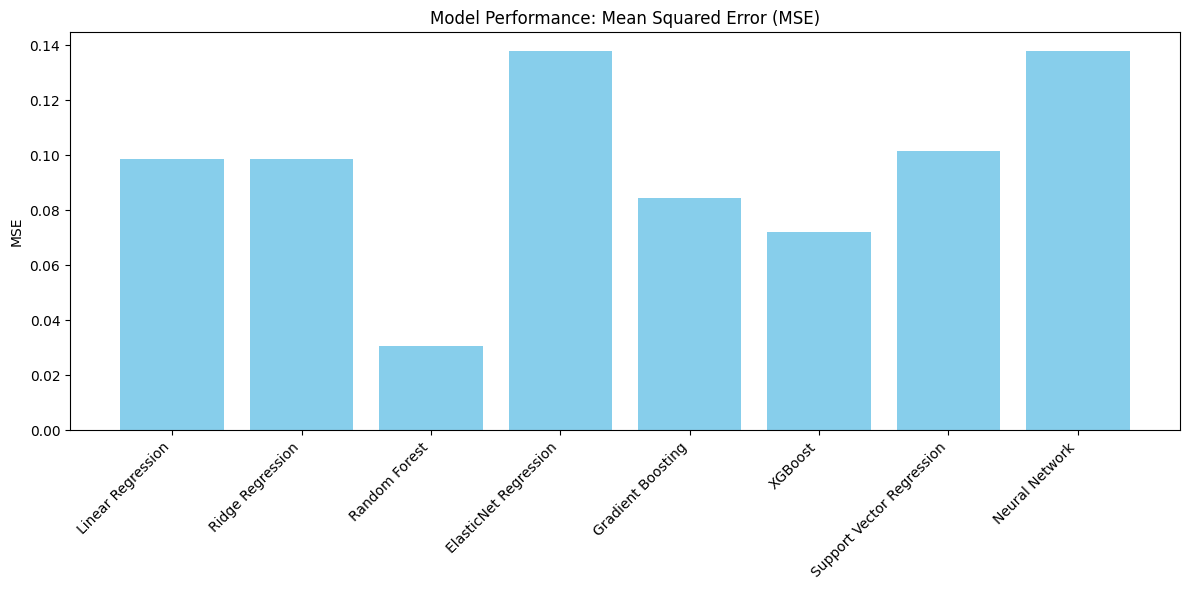

In [4]:
import matplotlib.pyplot as plt

# Extract model names, MSE
model_names = list(results.keys())
mse_values = [metrics['MSE'] for metrics in results.values()]


# Create a bar plot for MSE
plt.figure(figsize=(12, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Model Performance: Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



**<h4>4.2 Model Training - Regularization</h4>**

The code trains and evaluates multiple machine learning models on a dataset to predict the `Cmd_vel_v` (translational velocity) target variable, incorporating regularization techniques to improve model performance and generalization. The dataset is loaded and missing values are imputed using the mean strategy. A diverse set of models is employed, including linear models (Linear Regression, Ridge Regression), tree-based models (Random Forest, Gradient Boosting, XGBoost), neural networks (MLPRegressor), and support vector regression (SGDRegressor), each with specific regularization parameters like `alpha`, `max_depth`, and `learning_rate` to control complexity and reduce overfitting. Each model is trained, evaluated using metrics such as Mean Squared Error (MSE) and R² scores, and saved to disk for future use. This systematic approach enables model comparison and selection based on performance while leveraging regularization to balance bias and variance effectively.

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Load the dataset
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Impute missing values if any
print("Imputing missing values...")
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Models to train
# models = {
#     "Linear Regression": LinearRegression(),  # No explicit regularization
#     "Ridge Regression": Ridge(alpha=1.0),  # Regularization with alpha
#     "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, max_features="sqrt", random_state=42, n_jobs=-1),  # max_depth and max_features as regularization
#     "ElasticNet Regression": ElasticNet(alpha=0.5, l1_ratio=0.7, random_state=42),  # L1 and L2 regularization
#     "Gradient Boosting": GradientBoostingRegressor(n_estimators=30, max_depth=5, learning_rate=0.2, max_features="sqrt", random_state=42),  # max_depth and learning_rate control overfitting
#     "XGBoost": XGBRegressor(n_estimators=30, learning_rate=0.2, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42),  # subsample and colsample_bytree add regularization
#     "Support Vector Regression": SGDRegressor(max_iter=500, tol=1e-3, penalty='l2', alpha=0.0001, random_state=42),  # L2 penalty
#     "Neural Network": MLPRegressor(
#         hidden_layer_sizes=(50,), activation='relu', solver='adam',
#         max_iter=100, random_state=42, alpha=0.0001, learning_rate_init=0.01, early_stopping=True
#     )  # alpha for L2 regularization and early stopping
# }


models = {
    "Ridge Regression": Ridge(alpha=10),  # Increased regularization strength
    "Random Forest": RandomForestRegressor(
        n_estimators=50, max_depth=8, min_samples_split=5, min_samples_leaf=2, max_features="sqrt", random_state=42, n_jobs=-1
    ),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42),  # Lower alpha for less aggressive regularization
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=30, max_depth=3, learning_rate=0.1, subsample=0.8, max_features="sqrt", random_state=42
    ),
    "XGBoost": XGBRegressor(n_estimators=30, learning_rate=0.1, max_depth=4, subsample=0.7, colsample_bytree=0.7, reg_lambda=1, reg_alpha=0.1, random_state=42),

    "Support Vector Regression": SGDRegressor(max_iter=500, tol=1e-3, penalty='l2', alpha=0.001, random_state=42),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(50,), activation='relu', solver='adam',
        max_iter=200, random_state=42, alpha=0.001, learning_rate_init=0.01, early_stopping=True
    )
}


# Dictionary to store results
results = {}

# Train models and evaluate on training data
print("Training models...")
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train on 'Cmd_vel_v' target (translational velocity)
    model.fit(X, y['Cmd_vel_v'])

    # Predict on training set
    y_train_pred = model.predict(X)

    # Calculate errors
    mse = mean_squared_error(y['Cmd_vel_v'], y_train_pred)
    r2 = r2_score(y['Cmd_vel_v'], y_train_pred)
    results[model_name] = {"MSE": mse}

    # Save the model
    model_save_path = f"D:\\UMD\\Sem 3\\ENPM633 Introduction to Machine Learning\\Final_project\\{model_name.replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_save_path)
    print(f"{model_name} saved successfully to {model_save_path}.")
    print(f"{model_name} - MSE: {mse:.4f}")

# Display results
print("\nModel Performance with Regularization on Training Data:")
for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.4f}")


Loading data...
Imputing missing values...
Training models...
Training Ridge Regression...
Ridge Regression saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Ridge_Regression_model.pkl.
Ridge Regression - MSE: 0.0986
Training Random Forest...
Random Forest saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Random_Forest_model.pkl.
Random Forest - MSE: 0.0790
Training ElasticNet Regression...
ElasticNet Regression saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\ElasticNet_Regression_model.pkl.
ElasticNet Regression - MSE: 0.1378
Training Gradient Boosting...
Gradient Boosting saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Gradient_Boosting_model.pkl.
Gradient Boosting - MSE: 0.0961
Training XGBoost...
XGBoost saved successfully to D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\XGBoost_model.pkl.
XGBoost -

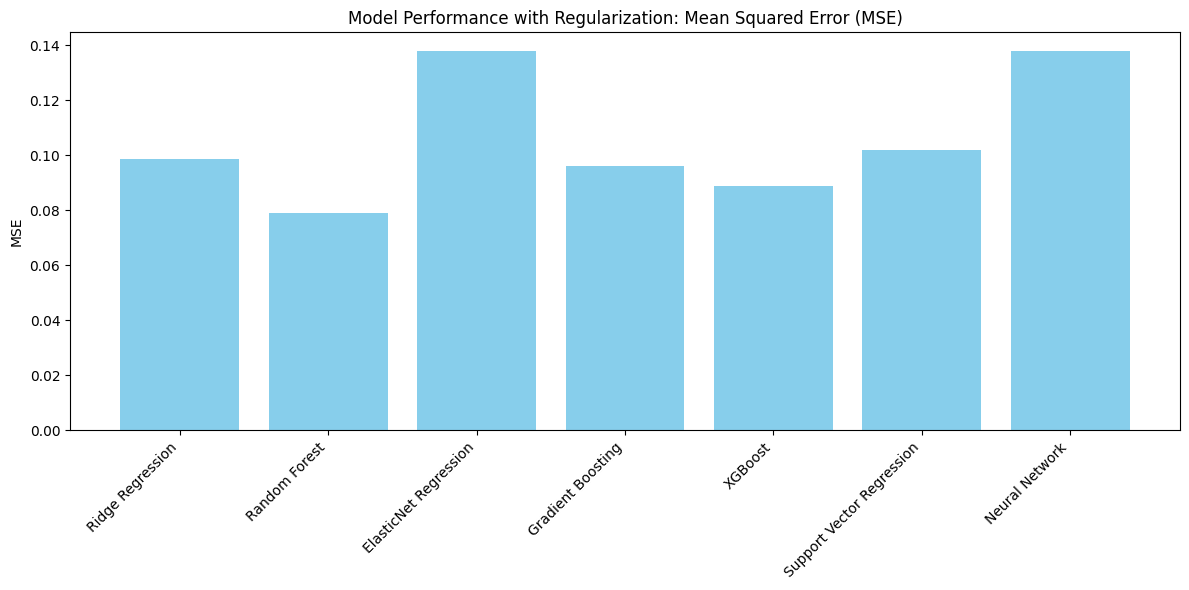

In [7]:
import matplotlib.pyplot as plt

# Extract model names, MSE, and R2 scores
model_names = list(results.keys())
mse_values = [metrics['MSE'] for metrics in results.values()]
# r2_values = [metrics['R2'] for metrics in results.values()]

# Create a bar plot for MSE
plt.figure(figsize=(12, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Model Performance with Regularization: Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**<h4>4.3 Model Training - Hyperparameter Selection</h4>**

The provided code performs hyperparameter tuning for multiple regression models using `RandomizedSearchCV` with a focus on computational efficiency. It processes a dataset in chunks to handle large data without memory issues, imputing missing values in each chunk using the mean. Each model, including Ridge Regression, Random Forest, ElasticNet, Gradient Boosting, XGBoost, Support Vector Regression, and Neural Network, has its own set of hyperparameters to explore within a predefined, limited range to minimize computational expense. The tuning is done using 5-fold cross-validation, optimizing for the negative mean squared error (MSE). Results for each model, including the best parameters and the corresponding MSE, are stored and displayed. This approach enables efficient exploration of optimal model configurations while managing memory constraints.

In [13]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features_batch1.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Chunk size for processing
chunk_size = 10000  # Number of rows to process in each chunk


# Define hyperparameter grids for each model
param_grids = {
    "Ridge Regression": {
        "model": Ridge(alpha=10),  # Default parameter
        "params": {
            "alpha": [0.1, 1, 10]  # Reduced range for faster search
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [10, 30, 50],  # Fewer estimators to reduce training time
            "max_depth": [3, 5, 8],  # Limited range for faster training
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt"]  # Focus on commonly used options
        }
    },
    "ElasticNet Regression": {
        "model": ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42),  # Tuned parameters
        "params": {
            "alpha": [0.01, 0.1],
            "l1_ratio": [0.5, 0.7]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [10, 30, 50],  # Reduced estimators
            "learning_rate": [0.1],  # Focus on a reasonable default value
            "max_depth": [3, 5],  # Simplify depth range
            "subsample": [0.8],  # Single option for efficiency
            "max_features": ["sqrt"]  # Most common choice
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [10, 30],  # Fewer estimators
            "learning_rate": [0.1],  # Focus on reasonable default
            "max_depth": [3, 5],  # Reduce tree depth
            "subsample": [0.7],  # Single commonly used value
            "colsample_bytree": [0.7],  # Single option for simplicity
            "reg_lambda": [1],  # Fixed regularization
            "reg_alpha": [0]  # Avoid unnecessary complexity
        }
    },
    "Support Vector Regression": {
        "model": SGDRegressor(max_iter=500, tol=1e-3, penalty='l2', alpha=0.001, random_state=42),
        "params": {
            "alpha": [0.001, 0.01],  # Reduced range
            "penalty": ["l2"],  # Fixed to most common option
            "max_iter": [500]  # Single iteration count for faster training
        }
    },
    "Neural Network": {
        "model": MLPRegressor(random_state=42, early_stopping=True),
        "params": {
            "hidden_layer_sizes": [(50,), (70,)],  # Smaller and simpler networks
            "alpha": [0.01],  # Single value for regularization
            "learning_rate_init": [0.01],  # Reasonable default for learning rate
            "max_iter": [50]  # Fewer iterations to reduce training time
        }
    }
}



# Dictionary to store best results
best_results = {}

# Perform RandomizedSearchCV for each model
print("Processing data in chunks...")
for model_name, model_info in param_grids.items():
    print(f"Hyperparameter tuning for {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=model_info["model"],
        param_distributions=model_info["params"],
        scoring="neg_mean_squared_error",
        cv=5,  # 5-fold cross-validation
        verbose=1,
        n_jobs=-1,
        n_iter=10  # Reduce iterations for faster tuning
    )

    # Read data in chunks
    X_chunks = pd.read_csv(X_final_path, chunksize=chunk_size)
    y_chunks = pd.read_csv(y_combined_path, chunksize=chunk_size)

    # Impute missing values before processing chunks
    imputer = SimpleImputer(strategy="mean")

    for X_chunk, y_chunk in zip(X_chunks, y_chunks):
        # Ensure proper column formatting
        X_chunk.columns = X_chunk.columns.str.strip()
        y_chunk.columns = y_chunk.columns.str.strip()

        # Impute missing values for the chunk
        X_chunk = pd.DataFrame(imputer.fit_transform(X_chunk), columns=X_chunk.columns)

        # Validate if shapes match
        if len(X_chunk) != len(y_chunk):
            print(f"Mismatch in chunk sizes: {len(X_chunk)} features, {len(y_chunk)} targets.")
            continue

        # Extract features and target
        if 'Cmd_vel_v' not in y_chunk.columns:
            raise KeyError("'Cmd_vel_v' column not found in the target data!")

        X_chunk = X_chunk.values
        y_chunk = y_chunk["Cmd_vel_v"].values  # Ensure correct column

        try:
            random_search.fit(X_chunk, y_chunk)
        except MemoryError:
            print(f"MemoryError during processing for {model_name}. Try reducing chunk size.")
            break

    best_results[model_name] = {
        "best_params": random_search.best_params_,
        "best_mse": -random_search.best_score_
    }
    print(f"Best Params for {model_name}: {random_search.best_params_}")
    print(f"Best MSE for {model_name}: {-random_search.best_score_:.4f}")

# Display results
print("\nBest Hyperparameters and MSE for Each Model:")
for model_name, result in best_results.items():
    print(f"{model_name}:")
    print(f"  Best Params: {result['best_params']}")
    print(f"  Best MSE: {result['best_mse']:.4f}")


Processing data in chunks...
Hyperparameter tuning for Ridge Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mismatch in chunk sizes: 280 features, 10000 targets.
Best Params for Ridge Regression: {'alpha': 10}
Best MSE for Ridge Regression: 0.0965
Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for 

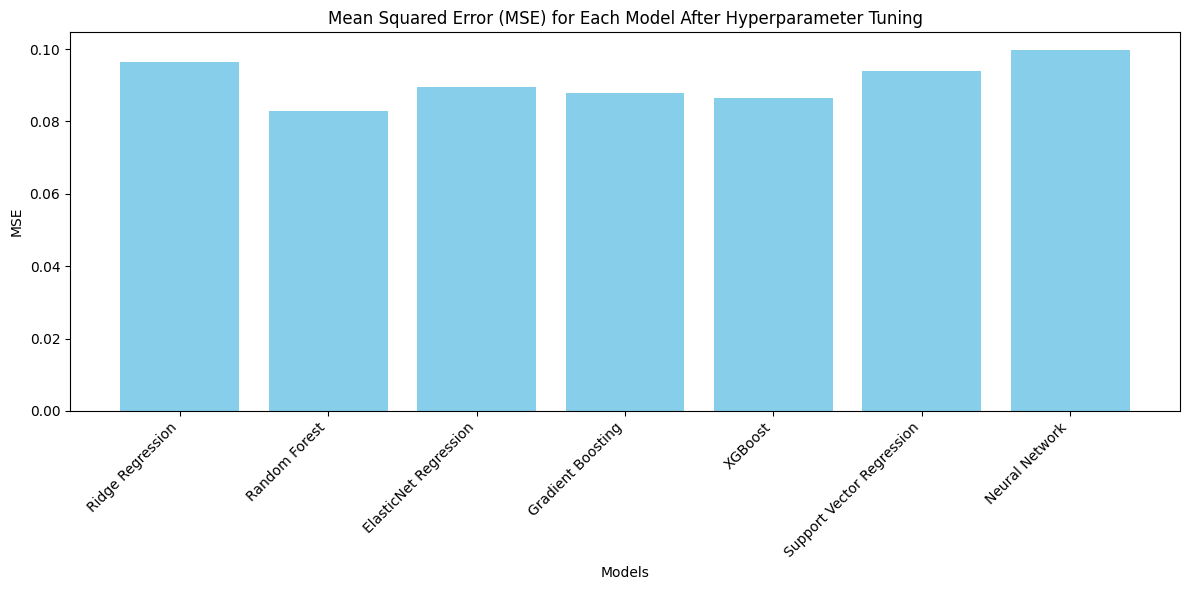

In [14]:
import matplotlib.pyplot as plt

# Extract model names and corresponding MSEs
model_names = list(best_results.keys())
mse_values = [result["best_mse"] for result in best_results.values()]

# Plot the MSEs
plt.figure(figsize=(12, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Mean Squared Error (MSE) for Each Model After Hyperparameter Tuning")
plt.ylabel("MSE")
plt.xlabel("Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**<h3>5. Cross - Validation</h3>**

**<h4>5.1 Cleaning Cross - Validation data</h4>**

This code cleans and preprocesses validation data files in a specified folder by handling missing values and removing duplicate entries. Each file is loaded as a DataFrame and assigned predefined column names corresponding to features like laser readings and robot goal positions. The missing values are imputed using the mean strategy with `SimpleImputer`, and duplicate rows are removed to ensure data consistency. The cleaned data is then saved to a specified directory, ensuring the output folder exists before processing. This process is applied to all `.csv` files in the folder, with each file being individually processed and saved, ensuring a clean and standardized dataset for further analysis or modeling.

In [2]:
import os
from sklearn.impute import SimpleImputer
import pandas as pd

# Define folder path for the dataset
validation_data_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data"
cleaned_validation_dataset = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset"

# Define column names based on README
column_names = ['Laser_' + str(i) for i in range(1, 1081)] + [
    'Final_goal_x', 'Final_goal_y', 'Final_goal_qk', 'Final_goal_qr',
    'Local_goal_x', 'Local_goal_y', 'Local_goal_qk', 'Local_goal_qr',
    'Robot_pos_x', 'Robot_pos_y', 'Robot_pos_qk', 'Robot_pos_qr',
    'Cmd_vel_v', 'Cmd_vel_w'
]

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Function to clean a single file
def clean_file(file_path):
    # Load data
    data = pd.read_csv(file_path, header=None)
    data.columns = column_names

    # Step 1: Handle missing values
    data.iloc[:, :] = imputer.fit_transform(data)

    # Step 2: Remove duplicates
    data.drop_duplicates(inplace=True)

    return data

# Ensure output directory exists
os.makedirs(cleaned_validation_dataset, exist_ok=True)

# Process files in the specified folder
for file_name in os.listdir(validation_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(validation_data_folder, file_name)
        print(f"Processing file: {file_path}")

        # Clean file
        cleaned_file_data = clean_file(file_path)

        # Save cleaned data
        save_path = os.path.join(cleaned_validation_dataset, file_name)
        cleaned_file_data.to_csv(save_path, index=False)
        print(f"Saved cleaned file: {save_path}")


Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data\July22_1.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_1.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data\July22_14.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_14.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data\July22_16.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_16.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_data\July22_2.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_2.csv
Processing file: D:\UMD\Sem 

**<h4>5.2 Preprocessing Cross - Validation data</h4>**

This code processes cleaned validation data files by imputing missing values, normalizing features, and reducing dimensionality using variance thresholding. It reads and processes data in batches and chunks to handle memory constraints. Each file is split into input features (laser data and robot positions) and target variables (`Cmd_vel_v` and `Cmd_vel_w`). Missing values are imputed with the mean, laser data is normalized between 0 and 1, and low-variance laser features are removed. Processed features and targets are stored batch-wise, and intermediate results are saved to disk. Finally, all batch results are concatenated and saved as complete validation features and targets datasets for model evaluation. This structured approach ensures efficient handling of large validation datasets.

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Path to the folder containing cleaned validation data
cleaned_validation_dataset = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset"

# Paths to save processed results
X_validation_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_features.csv"
y_validation_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_targets.csv"


# Chunk size and batch processing parameters
chunk_size = 1000  # Adjust based on available memory
batch_size = 5  # Number of files to process in one batch

# Variance Threshold Selector
selector = VarianceThreshold(threshold=0.001)

# Scaler and Imputer for preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
imputer = SimpleImputer(strategy='mean')

# Get all files from the validation folder
all_files = [f for f in os.listdir(cleaned_validation_dataset) if f.endswith('.csv')]
total_files = len(all_files)

print(f"Total validation files: {total_files}")

# Batch processing for validation files
for batch_start in range(0, len(all_files), batch_size):
    batch_files = all_files[batch_start:batch_start + batch_size]
    print(f"\nProcessing batch {batch_start // batch_size + 1} with files: {batch_files}")

    all_reduced_laser_data = []
    all_other_features = []
    all_targets = []

    # Process files in the current batch
    for file_name in batch_files:
        file_path = os.path.join(cleaned_validation_dataset, file_name)
        print(f"Processing file: {file_path}")

        # Read and process the file in chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Define input features (X) and target variables (y)
            X = chunk.iloc[:, :-2]  # All columns except 'Cmd_vel_v' and 'Cmd_vel_w'
            y = chunk.iloc[:, -2:]  # Targets ('Cmd_vel_v', 'Cmd_vel_w')

            # Impute missing values
            X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

            # Normalize laser range data
            X.iloc[:, :1080] = scaler.fit_transform(X.iloc[:, :1080])

            # Apply Variance Threshold to laser data
            laser_data = X.iloc[:, :1080]  # First 1080 columns
            reduced_laser_chunk = selector.fit_transform(laser_data)

            # Store reduced laser data and other features
            all_reduced_laser_data.append(pd.DataFrame(reduced_laser_chunk))
            all_other_features.append(X.iloc[:, 1080:])
            all_targets.append(y)

    # Combine processed data for the batch
    X_reduced_variance = pd.concat(all_reduced_laser_data, ignore_index=True)
    X_other_features = pd.concat(all_other_features, ignore_index=True)
    y_combined = pd.concat(all_targets, ignore_index=True)

    # Save intermediate results for the batch
    batch_features_path = X_validation_final_path.replace(".csv", f"_batch{batch_start // batch_size + 1}.csv")
    batch_targets_path = y_validation_combined_path.replace(".csv", f"_batch{batch_start // batch_size + 1}.csv")
    X_reduced_variance.to_csv(batch_features_path, index=False)
    y_combined.to_csv(batch_targets_path, index=False)
    print(f"Batch features saved to: {batch_features_path}")
    print(f"Batch targets saved to: {batch_targets_path}")

# Combine all batch results
print("\nCombining all batch results...")
batch_features_paths = [X_validation_final_path.replace(".csv", f"_batch{i+1}.csv") for i in range(len(all_files) // batch_size)]
batch_targets_paths = [y_validation_combined_path.replace(".csv", f"_batch{i+1}.csv") for i in range(len(all_files) // batch_size)]

final_features = pd.concat([pd.read_csv(path) for path in batch_features_paths], ignore_index=True)
final_targets = pd.concat([pd.read_csv(path) for path in batch_targets_paths], ignore_index=True)

# Save final combined data
final_features.to_csv(X_validation_final_path, index=False)
final_targets.to_csv(y_validation_combined_path, index=False)
print(f"Validation features saved to: {X_validation_final_path}")
print(f"Validation targets saved to: {y_validation_combined_path}")


Total validation files: 14

Processing batch 1 with files: ['July22_1.csv', 'July22_14.csv', 'July22_16.csv', 'July22_2.csv', 'July22_23.csv']
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_1.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_14.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_16.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_2.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_validation_dataset\July22_23.csv
Batch features saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_features_batch1.csv
Batch targets saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_ta

**<h4>5.3 Testing with Cross - Validation data</h4>**

This code evaluates the performance of several regression models with optimized hyperparameters using cross-validation on a validation dataset. The dataset is loaded and preprocessed by imputing missing values using the mean strategy. Models include Ridge Regression, Random Forest, ElasticNet, Gradient Boosting, XGBoost, Support Vector Regression, and Neural Networks, each configured with its best-performing hyperparameters. A 5-fold cross-validation process is performed for each model, calculating the mean and standard deviation of the Mean Squared Error (MSE) as the evaluation metric. Results for each model are stored and displayed, providing insights into their predictive performance on the validation dataset. This structured approach ensures robust evaluation and comparison of different models.

In [2]:
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_targets.csv"

# Load the dataset
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Impute missing values
print("Imputing missing values...")
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Define models with the best hyperparameters
models = {
    "Ridge Regression": Ridge(alpha=10),  # Best alpha value
    "Random Forest": RandomForestRegressor(
        n_estimators=50,  # Best n_estimators
        max_depth=5,  # Best max_depth
        min_samples_split=2,  # Best min_samples_split
        min_samples_leaf=2,  # Best min_samples_leaf
        max_features="sqrt",  # Best max_features
        random_state=42,  # Random state for reproducibility
        n_jobs=-1  # Use all processors
    ),
    "ElasticNet Regression": ElasticNet(
        l1_ratio=0.5,  # Best l1_ratio
        alpha=0.01,  # Best alpha
        random_state=42  # Random state for reproducibility
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        subsample=0.8,  # Best subsample
        n_estimators=30,  # Best n_estimators
        max_features="sqrt",  # Best max_features
        max_depth=3,  # Best max_depth
        learning_rate=0.1,  # Best learning_rate
        random_state=42  # Random state for reproducibility
    ),
    "XGBoost": XGBRegressor(
        subsample=0.7,  # Best subsample
        reg_lambda=1,  # Best reg_lambda
        reg_alpha=0,  # Best reg_alpha
        n_estimators=30,  # Best n_estimators
        max_depth=5,  # Best max_depth
        learning_rate=0.1,  # Best learning_rate
        colsample_bytree=0.7,  # Best colsample_bytree
        random_state=42  # Random state for reproducibility
    ),
    "Support Vector Regression": SGDRegressor(
        penalty="l2",  # Best penalty
        max_iter=500,  # Best max_iter
        alpha=0.01,  # Best alpha
        random_state=42  # Random state for reproducibility
    ),
    "Neural Network": MLPRegressor(
        max_iter=50,  # Best max_iter
        learning_rate_init=0.01,  # Best learning_rate_init
        hidden_layer_sizes=(70,),  # Best hidden_layer_sizes
        alpha=0.01,  # Best alpha
        random_state=42,  # Random state for reproducibility
        early_stopping=True  # Enable early stopping for better generalization
    )
}



# Perform cross-validation for each model
cv_results = {}
print("\nPerforming Cross-Validation...")
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    try:
        # Perform 5-fold cross-validation
        mse_scores = -cross_val_score(model, X, y["Cmd_vel_v"], scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
        # r2_scores = cross_val_score(model, X, y["Cmd_vel_v"], scoring="r2", cv=5, n_jobs=-1)

        # Store results
        cv_results[model_name] = {
            "MSE Mean": mse_scores.mean(),
            "MSE Std": mse_scores.std(),
            # "R² Mean": r2_scores.mean(),
            # "R² Std": r2_scores.std()
        }
        print(f"{model_name} - MSE Mean: {mse_scores.mean():.4f}")
    except Exception as e:
        print(f"Error during cross-validation for {model_name}: {e}")

# Display final cross-validation results
print("\nCross-Validation Results:")
for model_name, result in cv_results.items():
    print(f"{model_name}:")
    print(f"  MSE Mean: {result['MSE Mean']:.4f}, MSE Std: {result['MSE Std']:.4f}")



Loading data...
Imputing missing values...

Performing Cross-Validation...
Evaluating Ridge Regression...
Ridge Regression - MSE Mean: 0.1231
Evaluating Random Forest...
Random Forest - MSE Mean: 0.1177
Evaluating ElasticNet Regression...
ElasticNet Regression - MSE Mean: 0.1194
Evaluating Gradient Boosting...
Gradient Boosting - MSE Mean: 0.1164
Evaluating XGBoost...
XGBoost - MSE Mean: 0.1137
Evaluating Support Vector Regression...
Support Vector Regression - MSE Mean: 0.1209
Evaluating Neural Network...
Neural Network - MSE Mean: 0.1193

Cross-Validation Results:
Ridge Regression:
  MSE Mean: 0.1231, MSE Std: 0.0120
Random Forest:
  MSE Mean: 0.1177, MSE Std: 0.0116
ElasticNet Regression:
  MSE Mean: 0.1194, MSE Std: 0.0100
Gradient Boosting:
  MSE Mean: 0.1164, MSE Std: 0.0103
XGBoost:
  MSE Mean: 0.1137, MSE Std: 0.0123
Support Vector Regression:
  MSE Mean: 0.1209, MSE Std: 0.0096
Neural Network:
  MSE Mean: 0.1193, MSE Std: 0.0120


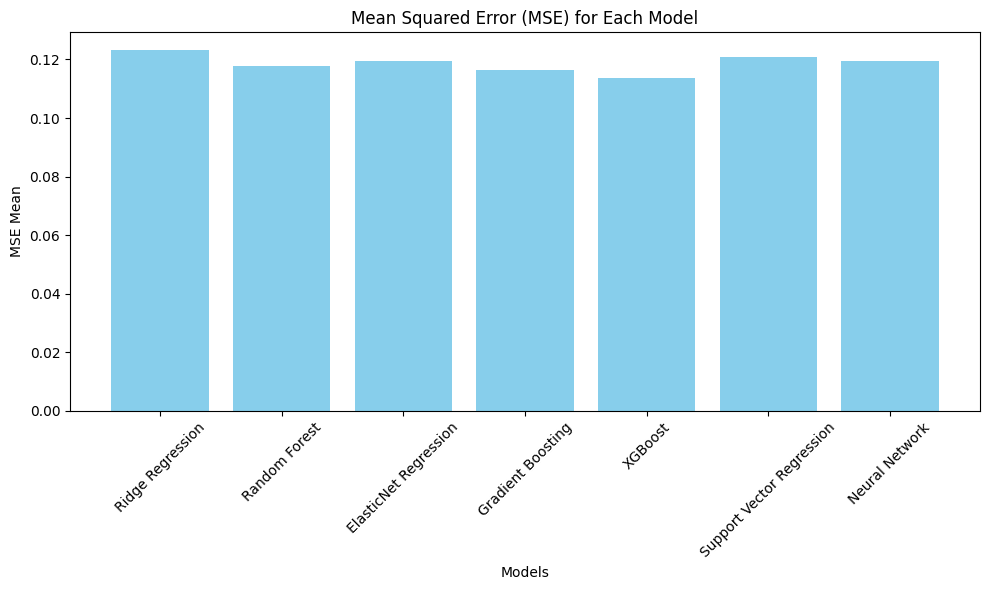

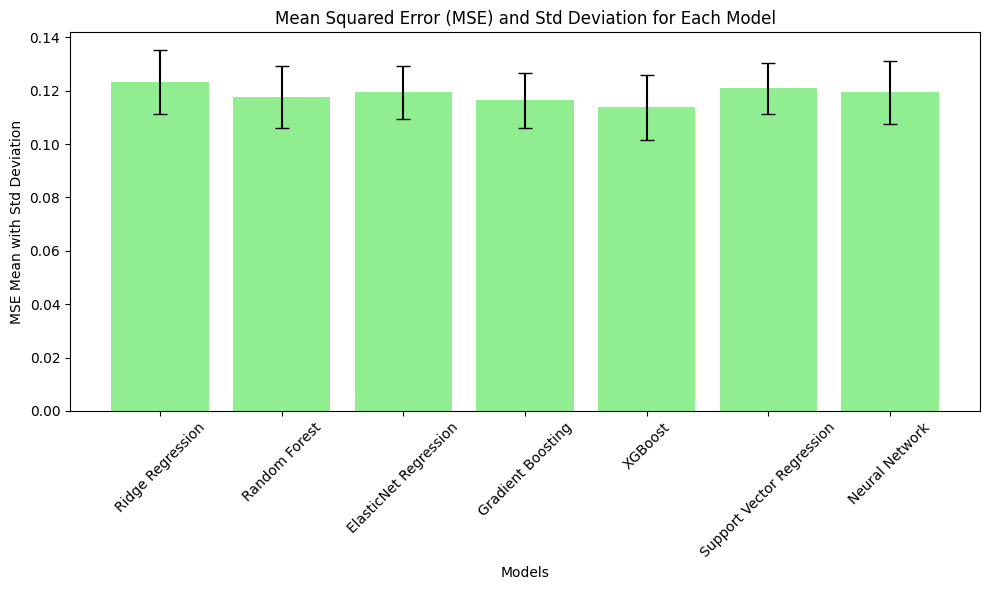

In [3]:
import matplotlib.pyplot as plt

# Extracting model names and their corresponding MSE mean and standard deviation
model_names = list(cv_results.keys())
mse_means = [cv_results[model]["MSE Mean"] for model in model_names]
mse_stds = [cv_results[model]["MSE Std"] for model in model_names]

# Plot 1: MSE Means for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_means, color="skyblue")
plt.xlabel("Models")
plt.ylabel("MSE Mean")
plt.title("Mean Squared Error (MSE) for Each Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: MSE Means with Standard Deviations
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_means, yerr=mse_stds, color="lightgreen", capsize=5)
plt.xlabel("Models")
plt.ylabel("MSE Mean with Std Deviation")
plt.title("Mean Squared Error (MSE) and Std Deviation for Each Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**<h4>5.4 Learning Curve of Best Model </h4>**

Loading data...
Generating learning curve for XGBoost...


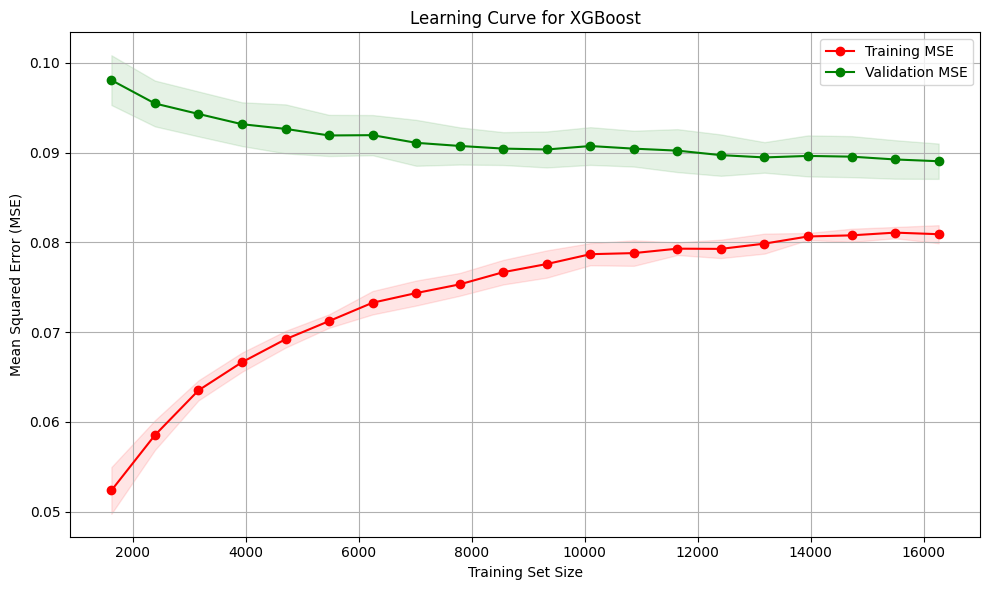

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, KFold
from xgboost import XGBRegressor
import pandas as pd

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\validation_targets.csv"

# Load a subset of the dataset
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Reduce dataset size (subsampling and shuffle)
subsample_fraction = 0.1  # Adjust subsample
X = X.sample(frac=subsample_fraction, random_state=42).reset_index(drop=True)
y = y.sample(frac=subsample_fraction, random_state=42).reset_index(drop=True)

# Extract target column
if 'Cmd_vel_v' in y.columns:
    y = y['Cmd_vel_v']
else:
    raise KeyError("'Cmd_vel_v' column not found in the target data!")

# Define the XGBoost model with best hyperparameters
model = XGBRegressor(
    subsample=0.7,  # Best subsample
    reg_lambda=1,  # Best reg_lambda
    reg_alpha=0,  # Best reg_alpha
    n_estimators=30,  # Best n_estimators
    max_depth=5,  # Best max_depth
    learning_rate=0.1,  # Best learning_rate
    colsample_bytree=0.7,  # Best colsample_bytree
    random_state=42  # Random state for reproducibility
)


# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 20), n_jobs=-1
    )

    # Calculate mean and std for train/test scores
    train_scores_mean = -np.mean(train_scores, axis=1)  # Convert negative MSE to positive
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MSE")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation MSE")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend(loc="best")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot the learning curve for XGBoost
print("Generating learning curve for XGBoost...")
plot_learning_curve(model, X, y, "XGBoost")


**<h4>5.5 Hyperparameter Tuning of Best Model </h4>**

This code performs hyperparameter tuning for the XGBoost regression model using `RandomizedSearchCV` to optimize its performance. The dataset is first loaded and subsampled to reduce memory usage and computation time. The target variable (`Cmd_vel_v`) is extracted, and a parameter grid is defined for tuning key hyperparameters such as the number of estimators, learning rate, maximum tree depth, subsampling rate, and regularization parameters. The `RandomizedSearchCV` tool is configured to evaluate 10 random combinations of these hyperparameters over 3-fold cross-validation, using the negative Mean Squared Error (MSE) as the scoring metric. The process is parallelized for efficiency, and histogram optimization is enabled in the XGBoost model for faster training. Finally, the best hyperparameter configuration and corresponding MSE score are displayed, allowing for the selection of the most effective model configuration.

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, DMatrix

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Load data
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Subsample if necessary (e.g., take 10% of the data)
subsample_fraction = 0.1
X = X.sample(frac=subsample_fraction, random_state=42).reset_index(drop=True)
y = y.sample(frac=subsample_fraction, random_state=42).reset_index(drop=True)

# Target column extraction
y = y['Cmd_vel_v']

# Define hyperparameter grid
param_grid = {
    "n_estimators": [10, 30],
    "learning_rate": [0.1],
    "max_depth": [3, 5],
    "subsample": [0.7],
    "colsample_bytree": [0.7],
    "reg_lambda": [1],
    "reg_alpha": [0]
}

# Initialize the XGBRegressor
model = XGBRegressor(random_state=42, tree_method="hist")  # Use histogram optimization for faster training

# Initialize RandomizedSearchCV
tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,                    # Reduce configurations for faster execution
    scoring='neg_mean_squared_error',
    cv=3,                         # Reduce CV folds to save memory
    verbose=1,
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

print("Performing Randomized Search...")
tuned_model.fit(X, y)

# Display best parameters and corresponding score
print(f"Best Parameters: {tuned_model.best_params_}")
print(f"Best MSE: {-tuned_model.best_score_:.4f}")


Loading data...
Performing Randomized Search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best MSE: 0.1008


**<h3>6. Training Best model on full training dataset<h3>**

This code trains an XGBoost regression model on the full training dataset using the best hyperparameters determined during tuning. It begins by loading the training features and target values from CSV files. The `Cmd_vel_v` column is extracted as the target variable for prediction. An XGBoost model is then initialized with optimized hyperparameters, such as a subsample ratio of 0.7, a regularization lambda of 1, 30 estimators, and a maximum depth of 5. The model is trained on the complete dataset, and predictions are made on the training set to evaluate performance using the Mean Squared Error (MSE). Finally, the trained model is saved as a pickle file for future use, and the MSE value is printed to summarize the model's training performance.

In [12]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import joblib
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold

# File paths
X_final_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_combined_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"

# Load the dataset
print("Loading data...")
X = pd.read_csv(X_final_path)
y = pd.read_csv(y_combined_path)

# Extract the target column
y_target = y['Cmd_vel_v']

# Initialize preprocessing objects
imputer = SimpleImputer(strategy='mean')  # Fill missing values with the mean
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale data between 0 and 1
selector = VarianceThreshold(threshold=0.001)  # Variance threshold for feature selection

# Apply preprocessing steps
print("Applying preprocessing steps...")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)
X_selected = pd.DataFrame(
    selector.fit_transform(X_scaled.iloc[:, :1080]),  # Apply to laser columns
    columns=[f"Laser_{i}" for i in range(selector.get_support().sum())]
)

# Save preprocessing objects for use on test/validation data
joblib.dump(imputer, r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\imputer.pkl")
joblib.dump(scaler, r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\scaler.pkl")
joblib.dump(selector, r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\selector.pkl")

# Save the feature names after preprocessing for consistent reference
# feature_names_save_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_feature_names.pkl"
final_feature_names = list(X_selected.columns) + list(X_scaled.columns[1080:])
joblib.dump(final_feature_names, feature_names_save_path)

# Combine reduced laser data with other features
X_final = pd.concat([X_selected, X_scaled.iloc[:, 1080:]], axis=1)

# Define the model
model = XGBRegressor(
    subsample=0.7,  # Best subsample
    reg_lambda=0.1,  # Best reg_lambda
    reg_alpha=0,  # Best reg_alpha
    n_estimators=50,  # Best n_estimators
    max_depth=7,  # Best max_depth
    learning_rate=0.1,  # Best learning_rate
    colsample_bytree=0.8,  # Best colsample_bytree
    random_state=42  # Random state for reproducibility
)

# Train the model
print("Training the XGBoost model...")
model.fit(X_final, y_target)

# Predict on the training set
y_train_pred = model.predict(X_final)

# Calculate performance metrics
mse = mean_squared_error(y_target, y_train_pred)
r2 = r2_score(y_target, y_train_pred)

# Save the trained model
model_save_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\XGBoost_model.pkl"
joblib.dump(model, model_save_path)

# Display results
print(f"Model saved to: {model_save_path}")
print(f"Feature names saved to: {feature_names_save_path}")
print("Training Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Loading data...
Applying preprocessing steps...
Training the XGBoost model...
Model saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\XGBoost_model.pkl
Feature names saved to: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\training_feature_names.pkl
Training Performance:
Mean Squared Error (MSE): 0.0572
R² Score: 0.5851


**<h3>7. Testing <h3>**

**<h4>7.1 Cleaning Test Data<h3>**

This script is designed to preprocess a collection of test data CSV files by performing data cleaning and saving the results into a specified folder. The code defines the expected column names based on the provided schema. For each file in the designated test data folder, the script loads the data without assuming pre-existing headers, assigns the correct column names, and checks for missing values, issuing a warning if any are found. Duplicates within the data are removed to ensure data integrity. After cleaning, the modified data is saved to a new location in the `cleaned_dataset` folder. The script ensures the output directory exists before processing, and logs its progress for each file, making it clear which files have been processed and saved.

In [21]:
import os
import pandas as pd

# Define folder path for the dataset
test_data_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Testing"
cleaned_dataset = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset"

# Define column names based on README
column_names = ['Laser_' + str(i) for i in range(1, 1081)] + [
    'Final_goal_x', 'Final_goal_y', 'Final_goal_qk', 'Final_goal_qr',
    'Local_goal_x', 'Local_goal_y', 'Local_goal_qk', 'Local_goal_qr',
    'Robot_pos_x', 'Robot_pos_y', 'Robot_pos_qk', 'Robot_pos_qr',
    'Cmd_vel_v', 'Cmd_vel_w'
]

# Function to clean a single file
def clean_file(file_path):
    # Load data
    data = pd.read_csv(file_path, header=None)
    data.columns = column_names

    # Step 1: Check for missing values (Warning)
    if data.isnull().values.any():
        print(f"Warning: Missing values detected in file {file_path}. Please handle appropriately.")

    # Step 2: Remove duplicates
    data.drop_duplicates(inplace=True)

    return data

# Ensure output directory exists
os.makedirs(cleaned_dataset, exist_ok=True)

# Process files in the specified folder
for file_name in os.listdir(test_data_folder):

    if file_name.endswith('.csv'):
        file_path = os.path.join(test_data_folder, file_name)
        print(f"Processing file: {file_path}")

        # Clean file
        cleaned_file_data = clean_file(file_path)

        # Save cleaned data
        save_path = os.path.join(cleaned_dataset, file_name)
        cleaned_file_data.to_csv(save_path, index=False)
        print(f"Saved cleaned file: {save_path}")


Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Testing\Aug14_Box_11.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_11.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Testing\Aug14_Box_3.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_3.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Testing\Aug14_Box_5.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_5.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\Testing\Aug14_Box_g1.csv
Saved cleaned file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_g1.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machin

**<h4>7.2 Preprocessing Test Data<h3>**

This code processes cleaned test dataset files for machine learning by applying feature scaling, feature selection, and separating features from targets. It starts by reading all files from a specified test dataset folder, assigning predefined column names, and converting non-numeric values to NaN. Rows with missing values are dropped to ensure clean data. The laser feature columns are normalized using a `MinMaxScaler`, and a `VarianceThreshold` is applied to remove low-variance features. The reduced laser features are combined with the other features, and all processed features and targets are stored for each file. After processing all files, the features and targets are concatenated into final datasets and saved as CSV files for subsequent analysis or model testing. This ensures a clean, consistent, and ready-to-use test dataset.

In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Paths
test_data_folder = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset"
X_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_features.csv"
y_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_targets.csv"

# Define expected column names
column_names = ['Laser_' + str(i) for i in range(1, 1081)] + [
    'Final_goal_x', 'Final_goal_y', 'Final_goal_qk', 'Final_goal_qr',
    'Local_goal_x', 'Local_goal_y', 'Local_goal_qk', 'Local_goal_qr',
    'Robot_pos_x', 'Robot_pos_y', 'Robot_pos_qk', 'Robot_pos_qr',
    'Cmd_vel_v', 'Cmd_vel_w'
]

# Initialize scaler and selector
scaler = MinMaxScaler(feature_range=(0, 1))
selector = VarianceThreshold(threshold=0.001)

# Storage for processed features and targets
all_features = []
all_targets = []

# Process each file in the test folder
all_files = [f for f in os.listdir(test_data_folder) if f.endswith('.csv')]

for file_name in all_files:
    file_path = os.path.join(test_data_folder, file_name)
    print(f"Processing file: {file_path}")

    # Read the file
    data = pd.read_csv(file_path, header=None, low_memory=False)
    data.columns = column_names

    # Convert non-numeric values to NaN
    data = data.apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN
    data.dropna(inplace=True)

    # Separate features and targets
    X = data.iloc[:, :-2].copy()  #Features except Cmd_vel_w and Cmd_vel_v
    y = data.iloc[:, -2:].copy()  # Targets Cmd_vel_w and Cmd_vel_v

    # Normalize laser data
    X.iloc[:, :1080] = scaler.fit_transform(X.iloc[:, :1080].copy())

    # Apply Variance Threshold
    reduced_laser_data = selector.fit_transform(X.iloc[:, :1080])

    # Combine reduced laser data with other features
    X_final = np.hstack((reduced_laser_data, X.iloc[:, 1080:].values))

    # Append to storage
    all_features.append(pd.DataFrame(X_final))
    all_targets.append(y)

# Combine all processed data
final_features = pd.concat(all_features, ignore_index=True)
final_targets = pd.concat(all_targets, ignore_index=True)

# Save to CSV
final_features.to_csv(X_test_path, index=False)
final_targets.to_csv(y_test_path, index=False)

print(f"Features saved to: {X_test_path}")
print(f"Targets saved to: {y_test_path}")


Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_11.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_3.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_5.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_g1.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_g11.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\Aug14_Box_g2.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\July22_11.csv
Processing file: D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\cleaned_test_dataset\July22_15.csv
Processing file: D:\UMD

**<h4>7.3 Testing on  Test Data<h3>**

This code demonstrates training and testing a machine learning model using the XGBoost Regressor. The training data (`X_train` for features and `y_train` for the target variable `Cmd_vel_v`) is first loaded from CSV files. An XGBoost Regressor is initialized with tuned hyperparameters and trained on the training dataset. For testing, the test features (`X_test`) and targets (`y_test`) are also loaded from their respective files. To ensure compatibility, the test features are aligned with the feature columns used during training. The model then predicts the target variable on the test set, and the performance is evaluated using the Mean Squared Error (MSE), which measures the model's prediction accuracy on the unseen test dataset.

Although the model had already been trained in previous steps, retraining was included here for several important reasons. It ensures consistency and reproducibility by revalidating that the final predictions and performance metrics align with expectations. Retraining also accommodates any updates or modifications to the training data, ensuring the model reflects the latest preprocessing steps or data adjustments. This approach avoids dependency on saved models, which could encounter compatibility or availability issues, and ensures alignment between training and test feature sets. Furthermore, retraining validates the correctness and completeness of the entire training pipeline, allowing for seamless automation or iteration over experiments. Overall, including the training step maintains a clean, traceable, and robust pipeline while enabling updates and ensuring alignment with the testing process.

In [1]:
import pandas as pd
from xgboost import XGBRegressor

# Paths
X_train_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_train_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"
X_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_features.csv"
y_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_targets.csv"

# Load training data
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)['Cmd_vel_v']  # Use specific target column

# Train the model
model = XGBRegressor(
    subsample=0.7, reg_lambda=0.1, reg_alpha=0,
    n_estimators=50, max_depth=7, learning_rate=0.1,
    colsample_bytree=0.8, random_state=42
)
model.fit(X_train, y_train)

# Load test data
X_test = pd.read_csv(X_test_path)

# Align test features with training features
training_feature_names = list(X_train.columns)
X_test = X_test[training_feature_names]  # Ensure consistent feature set

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance (if ground truth is available)
y_test = pd.read_csv(y_test_path)['Cmd_vel_v']
mse = ((y_test - y_test_pred) ** 2).mean()
print(f"Mean Squared Error on Test Set for V: {mse:.4f}")


Mean Squared Error on Test Set for V: 0.1168


For Angular Velocity (w)

In [2]:
import pandas as pd
from xgboost import XGBRegressor

# Paths
X_train_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_features.csv"
y_train_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\final_targets.csv"
X_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_features.csv"
y_test_path = r"D:\UMD\Sem 3\ENPM633 Introduction to Machine Learning\Final_project\test_targets.csv"

# Load training data
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)['Cmd_vel_w']  # Use specific target column

# Train the model
model = XGBRegressor(
    subsample=0.7, reg_lambda=0.1, reg_alpha=0,
    n_estimators=50, max_depth=7, learning_rate=0.1,
    colsample_bytree=0.8, random_state=42
)
model.fit(X_train, y_train)

# Load test data
X_test = pd.read_csv(X_test_path)

# Align test features with training features
training_feature_names = list(X_train.columns)
X_test = X_test[training_feature_names]  # Ensure consistent feature set

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance (if ground truth is available)
y_test = pd.read_csv(y_test_path)['Cmd_vel_w']
mse = ((y_test - y_test_pred) ** 2).mean()
print(f"Mean Squared Error on Test Set for W: {mse:.4f}")


Mean Squared Error on Test Set for W: 0.0715
